**Professor:** Enrique Garcia Ceja
**email:** enrique.gc@tec.mx

# Demo: Compare abnormal fish behaviors (oversampling and weighted model).

**Files: fishFeatures.csv**

Refer to the *fish-behaviors.pptx* presentation for details about the dataset.


In [107]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score

In [108]:
# Path to the dataset.
filepath = "../data/fishFeatures.csv"

# Read the data
dataset = pd.read_csv(filepath)

In [109]:
dataset.head()

,id,label,f.meanSpeed,f.sdSpeed,f.minSpeed,f.maxSpeed,f.meanAcc,f.sdAcc,f.minAcc,f.maxAcc
0,id1,normal,2.623236,2.228456,0.500000,8.225342,-0.053660,1.839475,-5.532760,3.500000
1,id2,normal,5.984859,3.820270,1.414214,15.101738,-0.038705,2.660073,-7.273932,7.058594
2,id3,normal,16.608716,14.502042,0.707107,46.424670,-1.000196,12.890386,-24.320298,30.714624
3,id5,normal,4.808608,4.137387,0.500000,17.204651,-0.281815,5.228209,-12.204651,15.623512
4,id6,normal,17.785747,9.926729,3.354102,44.240818,-0.537534,11.272472,-22.178067,21.768613


In [110]:
# remove id column
dataset = dataset.drop('id', axis=1)
dataset.head()


,label,f.meanSpeed,f.sdSpeed,f.minSpeed,f.maxSpeed,f.meanAcc,f.sdAcc,f.minAcc,f.maxAcc
0,normal,2.623236,2.228456,0.500000,8.225342,-0.053660,1.839475,-5.532760,3.500000
1,normal,5.984859,3.820270,1.414214,15.101738,-0.038705,2.660073,-7.273932,7.058594
2,normal,16.608716,14.502042,0.707107,46.424670,-1.000196,12.890386,-24.320298,30.714624
3,normal,4.808608,4.137387,0.500000,17.204651,-0.281815,5.228209,-12.204651,15.623512
4,normal,17.785747,9.926729,3.354102,44.240818,-0.537534,11.272472,-22.178067,21.768613


In [111]:
# Count labels
dataset['label'].value_counts()

label
normal      1093
abnormal      54
Name: count, dtype: int64

In [112]:
# Shuffle the dataset
from sklearn.utils import shuffle

seed = 1234 #set seed for reproducibility

np.random.seed(seed)

dataset = shuffle(dataset)

In [113]:
#Select features and class
features = dataset.drop('label', axis=1)

labels = dataset[['label']]

features = features.values.astype(float)

labels = labels.values

In [114]:
features.shape

(1147, 8)

In [115]:
# Convert labels to integers.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_int = le.fit_transform(labels.ravel())

In [116]:
print(labels[0])
print(labels_int[0])

['normal']
1


In [117]:
# One hot encode labels using the to_categorical function of keras.
labels = tf.keras.utils.to_categorical(labels_int, num_classes = 2)

In [118]:
labels[0:10,:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [119]:
# Split into train and test sets.
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels,
                                                                            test_size = 0.50, random_state = 1234)

In [120]:
# count unique values in train_labels
unique_labels, counts = np.unique(train_labels, axis=0, return_counts=True)
normal = counts[0]
abnormal = counts[1]

print("Normal: ", normal)
print("Abnormal: ", abnormal)

Normal:  547
Abnormal:  26


In [121]:
# Normalize features between 0 and 1
# Normalization parameters are learned just from the training data to avoid information injection.
from sklearn import preprocessing

normalizer = preprocessing.StandardScaler().fit(train_features)
train_normalized = normalizer.transform(train_features)
test_normalized = normalizer.transform(test_features)

### Define the model


In [122]:
# Define the model.
model = keras.Sequential([
    keras.layers.Dense(units = 16, input_shape=(8,), activation=tf.nn.relu),
    keras.layers.Dense(units = 8, activation=tf.nn.relu),
    keras.layers.Dense(units = 2, activation=tf.nn.softmax)
])

C:\Users\User\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [123]:
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298 (1.16 KB)

 Trainable params: 298 (1.16 KB)

 Non-trainable params: 0 (0.00 B)

None


In [124]:
# Calculate class weights.
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = abnormal + normal
weight_for_0 = (1 / abnormal) * (total / 2.0)
weight_for_1 = (1 / normal) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 11.02
Weight for class 1: 0.52


In [125]:
# Define the optimizer. Stochastic Gradient Descent in this case.
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

model.compile(optimizer = optimizer,
              loss = "categorical_crossentropy",
              metrics = ['accuracy'])

# Train the model.
history = model.fit(train_normalized, train_labels,
                    epochs = 100,
                    validation_split = 0.0,
                    batch_size = 256,
                    class_weight=class_weight,
                    verbose = 1)

Epoch 1/100


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0940 - loss: 0.6911
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0741 - loss: 0.5964
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0881 - loss: 0.5851
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1184 - loss: 0.5573
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1536 - loss: 0.5404
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1827 - loss: 0.5234
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2187 - loss: 0.5143
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2808 - loss: 0.5202 
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3926 - loss: 0.5032 
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4526 - loss: 0.5120 
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4948 - loss: 0.4864 
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5794 - loss: 0.49

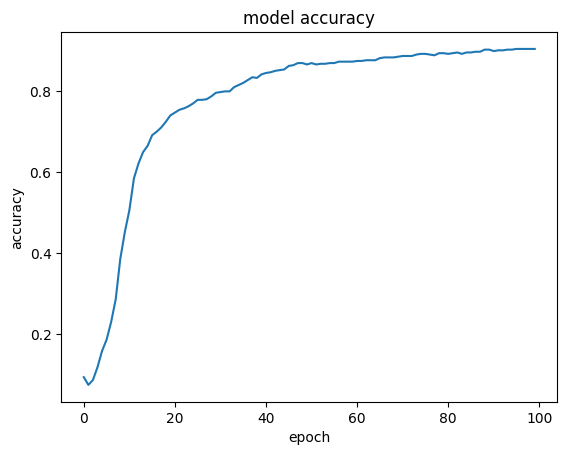

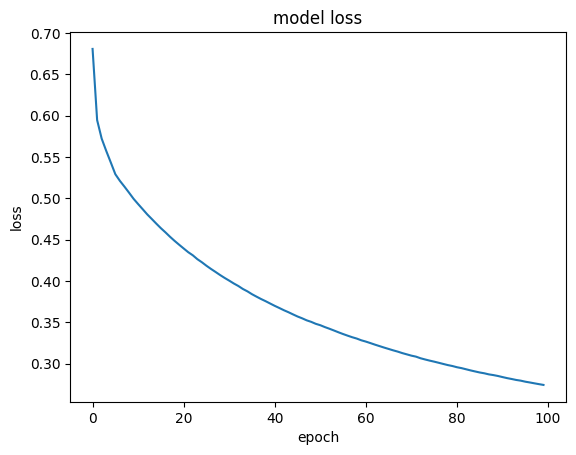

In [126]:
# Plot accuracy and loss curves

import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [127]:
# Evaluate the model on the test set and print the loss and accuracy.
model.evaluate(test_normalized, test_labels) # [loss, accuracy]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9263 - loss: 0.3312


[0.3695667088031769, 0.9163762927055359]

In [128]:
# Make predictions on the test set.
predictions = model.predict(test_normalized)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [129]:
# Print the first 5 predictions.
predictions[0:5]

array([[0.19104162, 0.8089584 ],
       [0.44952026, 0.5504797 ],
       [0.8938469 , 0.10615302],
       [0.19465633, 0.8053437 ],
       [0.16325381, 0.83674616]], dtype=float32)

The predictions are the probabilities for each of the classes. Thus, we need to get the class with the highest probability.

In [130]:
# Get the column index with max probability from predictions.
predictions_int = np.argmax(predictions, axis=1)

# Ground truth
true_values_int = np.argmax(test_labels, axis=1)

In [131]:
# Convert back to strings
predictions_str = le.inverse_transform(predictions_int)

true_values_str = le.inverse_transform(true_values_int)

In [132]:
pd.crosstab(true_values_str, predictions_str, rownames=['True labels'], colnames=['Predicted labels'])

Predicted labels,abnormal,normal
True labels,,
abnormal,25,3
normal,45,501


In [133]:
accuracy_score(true_values_str, predictions_str)

0.9163763066202091

In [134]:
recall_score(true_values_str, predictions_str, average=None)

array([0.89285714, 0.91758242])

# Now, train a model (without class weighting) by first oversampling the *train* data using SMOTE.

-Train a model with the same architecture as the previous one.
-Conduct your experiments below and compare the resuls between the weighted model and using SMOTE. Which method was better? Write your conclusions at the end.

In [135]:
# YOUR CODE HERE

# Define the model.
model_smote = keras.Sequential([
    keras.layers.Dense(units = 16, input_shape=(8,), activation=tf.nn.relu),
    keras.layers.Dense(units = 8, activation=tf.nn.relu),
    keras.layers.Dense(units = 2, activation=tf.nn.softmax)
])

C:\Users\User\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [136]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical

sm = SMOTE(
    sampling_strategy="minority",
    random_state=42,
    k_neighbors=5,
)

X_resampled, y_resampled = sm.fit_resample(train_normalized, train_labels)

y_resampled = to_categorical(y_resampled, num_classes=2)


In [137]:
# Define the optimizer. Stochastic Gradient Descent in this case.
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

model_smote.compile(optimizer = optimizer,
              loss = "categorical_crossentropy",
              metrics = ['accuracy'])

# Train the model.
history = model_smote.fit(X_resampled, y_resampled,
                    epochs = 100,
                    validation_split = 0.0,
                    batch_size = 256,
                    verbose = 1)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6024 - loss: 0.5609
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6227 - loss: 0.5465
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6478 - loss: 0.5265
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6871 - loss: 0.4998
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7102 - loss: 0.4932
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7524 - loss: 0.4692
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7897 - loss: 0.4585
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8221 - loss: 0.4462 
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8415 - loss: 0.4353 
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8376 - loss: 0.4270 
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8538 - loss: 0.4313
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8652 -

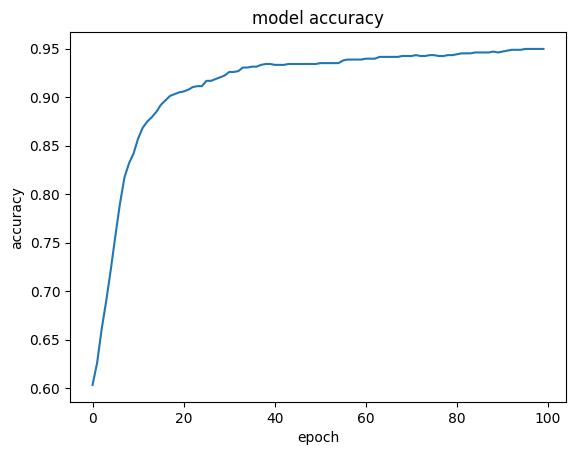

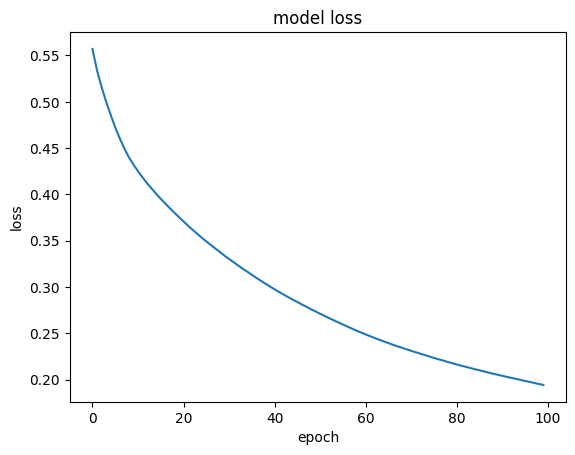

In [138]:
# Plot accuracy and loss curves

import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [139]:
# Evaluate the model on the test set and print the loss and accuracy.
model_smote.evaluate(test_normalized, test_labels) # [loss, accuracy]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9367 - loss: 0.2388


[0.2789207100868225, 0.9198606014251709]

In [140]:
predictions = model_smote.predict(test_normalized)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [141]:
# Get the column index with max probability from predictions.
predictions_int = np.argmax(predictions, axis=1)

# Ground truth
true_values_int = np.argmax(test_labels, axis=1)

In [142]:
# Convert back to strings
predictions_str = le.inverse_transform(predictions_int)

true_values_str = le.inverse_transform(true_values_int)

In [143]:
pd.crosstab(true_values_str, predictions_str, rownames=['True labels'], colnames=['Predicted labels'])

Predicted labels,abnormal,normal
True labels,,
abnormal,23,5
normal,41,505


In [144]:
accuracy_score(true_values_str, predictions_str)

0.9198606271777003

In [145]:
recall_score(true_values_str, predictions_str, average=None)

array([0.82142857, 0.92490842])

# Conclusions

El uso de SMOTE permitió incrementar artificialmente la cantidad de muestras de la clase minoritaria mediante interpolación sintética, logrando un conjunto de entrenamiento completamente balanceado. Dado que el modelo original utiliza categorical_crossentropy, fue necesario convertir las etiquetas generadas por SMOTE (que son enteros 0/1) nuevamente a formato one-hot para mantener compatibilidad con la arquitectura de salida del clasificador.

En resumen, la integración de SMOTE con la red neuronal se realizó correctamente, preservando la estructura y los requisitos del código original. En cuanto a la comparación entre las técnicas de class weighting y SMOTE, la segunda obtuvo un resultado ligeramente mejor (aunque casi insignificante) en términos de accuracy. Sin embargo, en términos de recall, SMOTE produjo un desempeño apenas superior para la clase mayoritaria, pero notablemente inferior para la clase minoritaria. Esto incrementó la diferencia entre los recalls de ambas clases, reduciendo el balance del modelo al clasificar los casos minoritarios, por lo que preferimos utilizar class weighting para esta situación.